# MAHMOUDI Ryad


# Projet Final Kit Data Science 



In [1]:
import requests
import datetime
import xlwings
from bs4 import BeautifulSoup
import pandas as pd
import re
import locale
import datetime
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
locale.setlocale(locale.LC_ALL, 'fr')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
sns.set_style("darkgrid")

In [2]:
#Fonction pour convertir les Latitudes/longitudes en décimal
def dms2dec(dms_str):
    dms_str = re.sub(r'\s', '', dms_str)
    sign = -1 if re.search('[swSW]', dms_str) else 1
    numbers = [*filter(len, re.split('\D+', dms_str, maxsplit=4))]
    degree = numbers[0]
    minute = numbers[1] if len(numbers) >= 2 else '0'
    second = numbers[2] if len(numbers) >= 3 else '0'
    frac_seconds = numbers[3] if len(numbers) >= 4 else '0'
    second += "." + frac_seconds
    return sign * (int(degree) + float(minute) / 60 + float(second) / 3600)

In [3]:
#récupération de la liste des fichiers depuis le site internet, on les met ensuite dans une liste

req = requests.get("https://www.vendeeglobe.org/fr/classement")
soup = BeautifulSoup(req.content)
list_fichiers = soup.find_all("select",{'class':"form__input m--select onsubmit-rank"})[0].find_all("option",{'value':re.compile('[0-9]+')})
for i in range(len(list_fichiers)):
    list_fichiers[i]="vendeeglobe_"+str(list_fichiers[i]).split('"')[1]+".xlsx"

In [4]:
#Télechargement des fichiers et stockage sur le disque dure

def download_xslx(url_download,list_files):
    for element in list_files:
        r = requests.get(url_download+element)
        output = open("Data/"+element, 'wb')
        output.write(r.content)
        output.close()
    return

# url_download = "https://www.vendeeglobe.org/download-race-data/"
# download_xslx(url_download,list_fichiers)

#Reparer les fichier xlsx sinon erreur : __init__() got an unexpected keyword argument 'xxid'

def xlsx_broken(file):
    excel_app = xlwings.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save()
    excel_book.close()
    excel_app.quit()
    return

# for element in list_fichiers:
#     xlsx_broken("Data/"+element)

In [5]:
#Récuperation/Scrapping des caractéristiques de chaque bateau

def parsing_infos_bateaux():
    r = requests.get("https://www.vendeeglobe.org/fr/glossaire")
    soup = BeautifulSoup(r.content)
    res = soup.find_all('div',{'class': "sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6"})
    boat_infos={}
    for result in res:
        Nom_bateau = result.find('h3',{'class':"boats-list__boat-name"}).text.title()
        Nom_skipper = result.find('span',{'class':"boats-list__skipper-name"}).text.replace('  ', ' ').title() #enlever double espace
        Num_voile =str(result.find(text=re.compile('Numéro de voile')))
        Anciens_noms = str(result.find(text=re.compile('Anciens noms du bateau')))
        Architecte = str(result.find(text=re.compile('Architecte')))
        Chantier = str(result.find(text=re.compile('Chantier')))
        Date_lancement = str(result.find(text=re.compile('Date de lancement')))
        Longueur = str(result.find(text=re.compile('Longueur')))
        Largeur = str(result.find(text=re.compile('Largeur')))
        Tirant_eau = str(result.find(text=re.compile("Tirant d'eau")))
        Poids = str(result.find(text=re.compile('poids')))
        Nb_derives = str(result.find(text=re.compile('Nombre de dérives')))
        Hauteur_mat = str(result.find(text=re.compile('Hauteur mât')))
        Voile_quille = str(result.find(text=re.compile('Voile quille')))
        Surf_pres = str(result.find(text=re.compile('Surface de voiles au près')))
        Surf_portant = str(result.find(text=re.compile('Surface de voiles au portant')))

        boat_infos[Nom_skipper]={   
            'Bateau':Nom_bateau,
            'Numéro de voile':Num_voile.split(' : ')[1] if Num_voile != 'None' else None, 
            'Anciens noms du bateau':Anciens_noms.split(' : ')[1] if Anciens_noms != 'None' else 'NaN', 
            'Architecte':Architecte.split(' : ')[1] if Architecte != 'None' else 'None',
            'Chantier':Chantier.split(' : ')[1] if Chantier != 'None' else None, 
            'Date de lancement':Date_lancement.split(' : ')[1] if Date_lancement != 'None' else None, 
            'Longueur':Longueur.split(' : ')[1] if Longueur != 'None' else None,
            'Largeur':Largeur.split(' : ')[1] if Largeur != 'None' else None,
            "Tirant d'eau":Tirant_eau.split(' : ')[1] if Tirant_eau != 'None' else None,
            'Déplacement (poids)':Poids.split(' : ')[1] if Poids != 'None' else None,
            'Nombre de dérives':Nb_derives.split(' : ')[1] if Nb_derives != 'None' else None,
            'Hauteur mât':Hauteur_mat.split(' : ')[1] if Hauteur_mat != 'None' else None,
            'Voile quille':Voile_quille.split(' : ')[1] if Voile_quille != 'None' else None,
            'Surface de voiles au près':Surf_pres.split(' : ')[1] if Surf_pres != 'None' else None,
            'Surface de voiles au portant':Surf_portant.split(' : ')[1] if Surf_portant != 'None' else None,  
        }
    return boat_infos
        

In [6]:
infos_bateaux = parsing_infos_bateaux()

In [7]:
#Fonction pour importer dans un DataFrame et nettoyer un fichier excel
def excel_to_df(file):
    
    df = pd.read_excel("Data/"+file,header=[3,4],nrows=33)
    df = df.rename(columns=lambda x: x if not 'Unnamed' in str(x) else '')
    df=df.drop(labels='',axis=1)
    df = df.rename(columns=lambda x: x.split('\n')[0])

    index =[
        'Rang',
        'Nat. / Voile',
        'Skipper / Bateau',
        'Heure FR',
        'Latitude',
        'Longitude',
        'Depuis 30 minutes Cap',
        'Depuis 30 minutes Vitesse',
        'Depuis 30 minutes VMG',
        'Depuis 30 minutes Distance',
        'Depuis le dernier classement Cap',
        'Depuis le dernier classement Vitesse',
        'Depuis le dernier classement VMG',
        'Depuis le dernier classement Distance',
        'Depuis 24 heures Cap',
        'Depuis 24 heures Vitesse',
        'Depuis 24 heures VMG',
        'Depuis 24 heures Distance',
        'DTF',
        'DTL'  
    ]

    df.columns = index
    
    #Split des colonnes Skipper/Bateau et Nat./Voile
    df[['Skipper','Bateau']]=df['Skipper / Bateau'].str.split('\n',expand=True)
    df[['Nationalité','Num. Voile']] = df['Nat. / Voile'].str.replace('\n','').str.split(' ',expand=True)
    df = df.drop(['Nat. / Voile','Skipper / Bateau'],axis=1)

    
    df.loc[df['Nationalité'].str.contains("FR"),'Nationalité'] = 'FRA' #supprimer les FRFRA
    
    df["Heure FR"]=df["Heure FR"].str.split(" FR").str[0] #On garde uniquement l'heure, suppression du texte
    
    #Mapping entre les noms issues des infos récupérées sur le site et le dataframe
    list_noms = list(infos_bateaux)
    list_noms.sort()
    mapping_noms = {df["Skipper"].sort_values(ignore_index=True)[i]:list_noms[i] for i in range(len(list_noms))}
    df["Skipper"]=df["Skipper"].map(mapping_noms)

    #Mapping entre les fichiers excel et les caracteristiques des bateaux
    dfcarac = pd.DataFrame(infos_bateaux).transpose()

    out = (df.merge(dfcarac, left_on='Skipper', right_index=True,copy=False))
    out=out.drop("Bateau_x",axis=1)
    out=out.drop("Numéro de voile",axis=1)

    out.rename(columns = {'Bateau_y' : 'Bateau'}, inplace = True)
    out=out.iloc[:, [0]+list(range(18,35))+list(range(1,18))] #reordonner les colonnes
    
    out.loc[out['Nombre de dérives'].str.contains("foil"),'Nombre de dérives'] = 'foils' #remplacer les 'foiler' par 'foils'
    
    #Formater les types
    
    #Création colonne Date = Date+Heure et suppression de la colonne Heure FR
    out.insert(0,"Date",pd.Series(pd.to_datetime(file.split("_")[1]+" "+df["Heure FR"])))
    out.drop(labels="Heure FR",axis=1,inplace=True)

    #Date de lancement -> type : date
    out["Date de lancement"]=out["Date de lancement"].apply(lambda x: datetime.datetime.strptime(x, '%d %B %Y'))
    
    #Longeur -> type : float
    out["Longueur"]=out["Longueur"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Largeur -> type : float
    out["Largeur"]=out["Largeur"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Tirant d'eau -> type : float
    out["Tirant d'eau"]=out["Tirant d'eau"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Poids -> type : tonne
    out["Déplacement (poids)"]=out["Déplacement (poids)"].str.split("t").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out.rename(columns={"Déplacement (poids)":'Poids'},inplace=True)
    
    #Hauteur du mât -> type : float
    out["Hauteur mât"]=out["Hauteur mât"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Surface de voiles au près -> type : int
    out["Surface de voiles au près"]=out["Surface de voiles au près"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Surface de voiles au portant -> type : int
    out["Surface de voiles au portant"]=out["Surface de voiles au portant"].str.split("m").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Cap -> type : float
    out[("Depuis 30 minutes Cap")]=out[("Depuis 30 minutes Cap")].str.split("°").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement Cap")]=out[("Depuis le dernier classement Cap")].str.split("°").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures Cap")]=out[("Depuis 24 heures Cap")].str.split("°").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Vitesse -> type : float
    out[("Depuis 30 minutes Vitesse")]=out[("Depuis 30 minutes Vitesse")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement Vitesse")]=out[("Depuis le dernier classement Vitesse")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures Vitesse")]=out[("Depuis 24 heures Vitesse")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')

    #VMG -> type : float
    out[("Depuis 30 minutes VMG")]=out[("Depuis 30 minutes VMG")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement VMG")]=out[("Depuis le dernier classement VMG")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures VMG")]=out[("Depuis 24 heures VMG")].str.split("kts").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Distance -> type : float
    out[("Depuis 30 minutes Distance")]=out[("Depuis 30 minutes Distance")].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis le dernier classement Distance")]=out[("Depuis le dernier classement Distance")].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    out[("Depuis 24 heures Distance")]=out[("Depuis 24 heures Distance")].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #DTL -> type : float
    out["DTF"]=out["DTF"].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #DTF -> type : float
    out["DTL"]=out["DTL"].str.split("nm").str[0].str.replace(',','.').apply(pd.to_numeric,errors='coerce')
    
    #Rang -> type : int 
    out['Rang']=out['Rang'].apply(pd.to_numeric,errors='coerce')
    out=out.dropna(axis=0,subset=out.columns[[1]])
    out['Rang']=out['Rang'].astype(int)
    
    #Latitude,Longitude -> type : decimal
    out["Latitude"]=df["Latitude"].map(lambda x: dms2dec(x) if type(x) == str else x)
    out["Longitude"]=df["Longitude"].map(lambda x: dms2dec(x) if type(x) == str else x)
    
    return out

### Chargement des fichiers dans un DataFrame

In [8]:
#Dernier fichier avant 1er arrivé : vendeeglobe_20210127_140000.xlsx
index_dernier = len(list_fichiers)-list_fichiers.index("vendeeglobe_20210127_140000.xlsx")
list_a_charger = list_fichiers[-index_dernier:][::-1][1:] #On ne prend pas en compte le 1er fichier qui est vide

df=pd.DataFrame()#Initialisation d'un nouveau DataFrame

#traitement des fichiers puis concatenation pour les ajouter au df
for file in list_a_charger:
    df=pd.concat(objs=[df,excel_to_df(file)],axis=0)

C:\Users\ryadm\anaconda3\envs\DataRyad\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [9]:
df

,Date,Rang,Skipper,Nationalité,Num. Voile,Bateau,Anciens noms du bateau,Architecte,Chantier,Date de lancement,...,Depuis le dernier classement Cap,Depuis le dernier classement Vitesse,Depuis le dernier classement VMG,Depuis le dernier classement Distance,Depuis 24 heures Cap,Depuis 24 heures Vitesse,Depuis 24 heures VMG,Depuis 24 heures Distance,DTF,DTL
0,2020-11-08 15:30:00,1,Louis Burton,FRA,18,Bureau Vallee 2,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,2015-06-09,...,357.0,0.0,0.0,2788.0,201.0,0.3,0.3,6.1,24293.9,0.0
1,2020-11-08 15:31:00,2,Boris Herrmann,MON,10,Seaexplorer - Yacht Club De Monaco,"Edmond de Rothschild, Malizia - Yacht Club de ...",Verdier - VPLP,Multiplast,2015-08-07,...,357.0,0.0,0.0,2787.9,196.0,0.3,0.2,6.0,24294.2,0.4
2,2020-11-08 15:30:00,3,Jérémie Beyou,FRA,8,Charal,NaN,VPLP,CDK Technologies,2018-08-18,...,357.0,0.0,0.0,2788.5,199.0,0.2,0.2,5.5,24294.3,0.5
3,2020-11-08 15:30:00,4,Thomas Ruyant,FRA,59,Linkedout,NaN,Verdier,Persico,2019-09-03,...,357.0,0.0,0.0,2788.3,196.0,0.2,0.2,5.6,24294.5,0.6
4,2020-11-08 15:30:00,5,Maxime Sorel,FRA,53,V And B-Mayenne,"Le Souffle du Nord, Groupe Bel",Verdier - VPLP,"Indiana Yachting (Scarlino, Italie)",2007-09-07,...,357.0,0.0,0.0,2788.1,195.0,0.8,0.7,5.8,24294.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,2021-01-27 14:30:00,21,Manuel Cousin,FRA,71,Groupe Sétin,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),2007-02-02,...,355.0,13.7,13.0,41.1,351.0,12.9,12.0,310.4,4521.7,4441.2
21,2021-01-27 14:30:00,22,Miranda Merron,FRA,50,Campagne De France,"Great America IV, Mirabaud, Temenos",Owen Clarke,"Southern Ocean Marine, Tauranga",2006-05-04,...,349.0,11.8,10.8,35.5,352.0,10.5,9.8,252.0,4639.1,4558.6
22,2021-01-27 14:30:00,23,Clément Giraud,FRA,83,Compagnie Du Lit / Jiliti,"Delta Dore, Bureau Vallée, Vers un Monde sans ...",Bruce Farr design,JMV Cherbourg,2006-07-26,...,1.0,10.1,9.8,30.3,340.0,9.6,7.9,230.4,4674.6,4594.1
23,2021-01-27 14:30:00,24,Alexia Barrier,FRA,72,Tse - 4Myplanet,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,...,23.0,9.1,9.0,27.3,29.0,11.4,11.4,273.7,6341.5,6260.9


### Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

In [10]:
X=df.loc[df["Depuis 24 heures VMG"]>0,"Depuis 24 heures VMG"].values.reshape(-1,1)
Y=df.loc[df["Depuis 24 heures VMG"]>0,'Rang'].values
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.25, random_state=0)

In [11]:
linearRegr=LinearRegression().fit(X_train,Y_train)

In [12]:
Y_pred=linearRegr.predict(X_test)

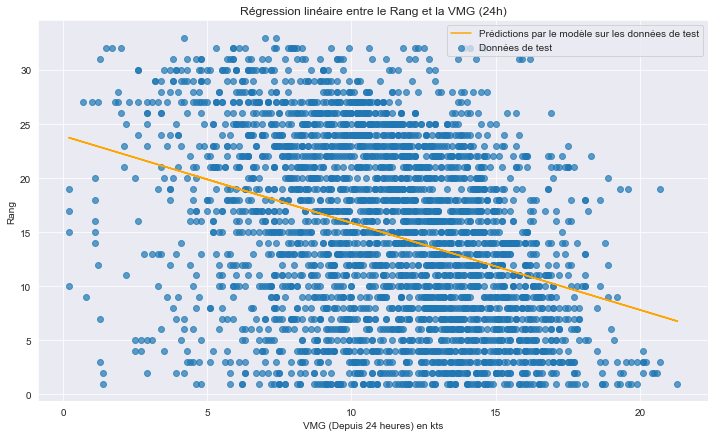

In [13]:
fig = plt.figure(figsize=(12, 7));
ax = fig.add_subplot()
ax.scatter(x=X_test, y=Y_test, alpha=0.7, label='Données de test')
ax.plot(X_test, Y_pred, color='orange', alpha=1, label='Prédictions par le modèle sur les données de test')

ax.set_xlabel('VMG (Depuis 24 heures) en kts');
ax.set_ylabel('Rang');
ax.set_title('Régression linéaire entre le Rang et la VMG (24h)');
ax.legend()
plt.show()

### Impact de la présence d'un foil sur le classement et la vitesse des voiliers.

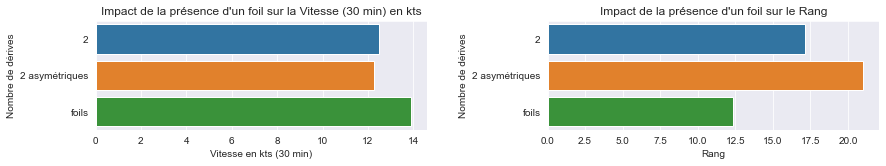

In [14]:
#Création de la figure
fig=plt.figure(figsize=(13, 3))

#Sélection des colonnes Rang, Nombre de dérives et vitesse depuis 30 min
var = df[["Rang","Nombre de dérives",'Depuis 30 minutes Vitesse']]

#Groupby Nombre de dérives et moyenne
var=var.groupby("Nombre de dérives").agg('mean')

#Subplots
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#Tracé de la vitesse  en fonction du nombre de dérives
sns.barplot(data=var, x='Depuis 30 minutes Vitesse', y=var.index,ax=ax1)
ax1.set_title("Impact de la présence d'un foil sur la Vitesse (30 min) en kts")
ax1.set_ylabel("Nombre de dérives")
ax1.set_xlabel("Vitesse en kts (30 min)")
#Tracé du rang en fonction du nombre de dérive
sns.barplot(data=var, x='Rang', y=var.index,ax=ax2)
ax2.set_title("Impact de la présence d'un foil sur le Rang")
ax2.set_ylabel("Nombre de dérives")


fig.tight_layout(pad=3.2) #sépration horizontale
plt.show()


On peut s'appercevoir que les bateaux équipés de foils sont plus performants :
- Ils ont une vitesse plus élévée en moyenne
- Ils sont en moyenne mieux classés

Les bateaux équipés de 2 dérives asymétriques sont en moyenne les moins performants

### Visualisation de la distance parcourue par voilier.

#### Evolution de la distance parcourue jour après jour

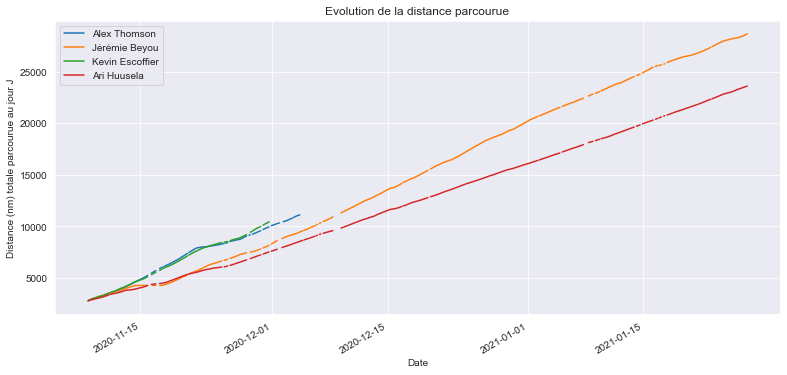

In [15]:
#Séléction de 4 Skipper au hasard
Skipper_choice = np.random.choice(df['Skipper'].unique(), 4,replace=False)

#Tracé de l'évolution de la distance parcourue
fig, ax = plt.subplots(figsize=(13,6))
df.pivot_table(index='Date',columns="Skipper",values="Depuis le dernier classement Distance")[Skipper_choice].cumsum().plot(ax=ax)

plt.xlabel("Date")
plt.ylabel("Distance (nm) totale parcourue au jour J")
plt.title("Evolution de la distance parcourue")
plt.legend()
plt.show()


#### Distance moyenne parcourue par jour par chaque Skipper

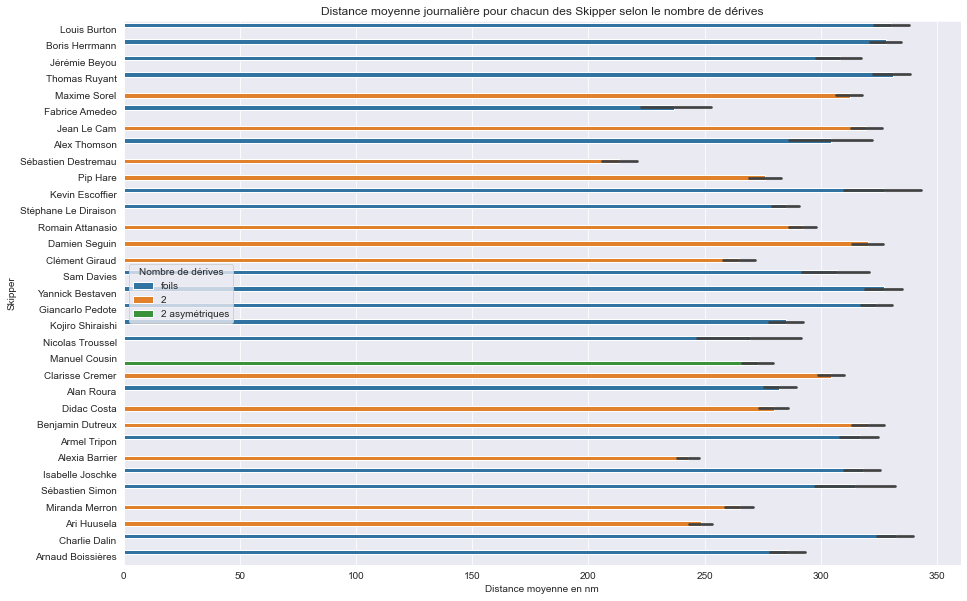

In [16]:
fig3=plt.figure(figsize=(15, 10))
sns.barplot(data=df, x='Depuis 24 heures Distance', y="Skipper",hue="Nombre de dérives")
plt.xlabel("Distance moyenne en nm")
plt.title("Distance moyenne journalière pour chacun des Skipper selon le nombre de dérives")
plt.show()

#### Impact de la date de lancement du Bateau sur la vitesse

<AxesSubplot:xlabel='Depuis 24 heures Vitesse', ylabel='Date de lancement'>

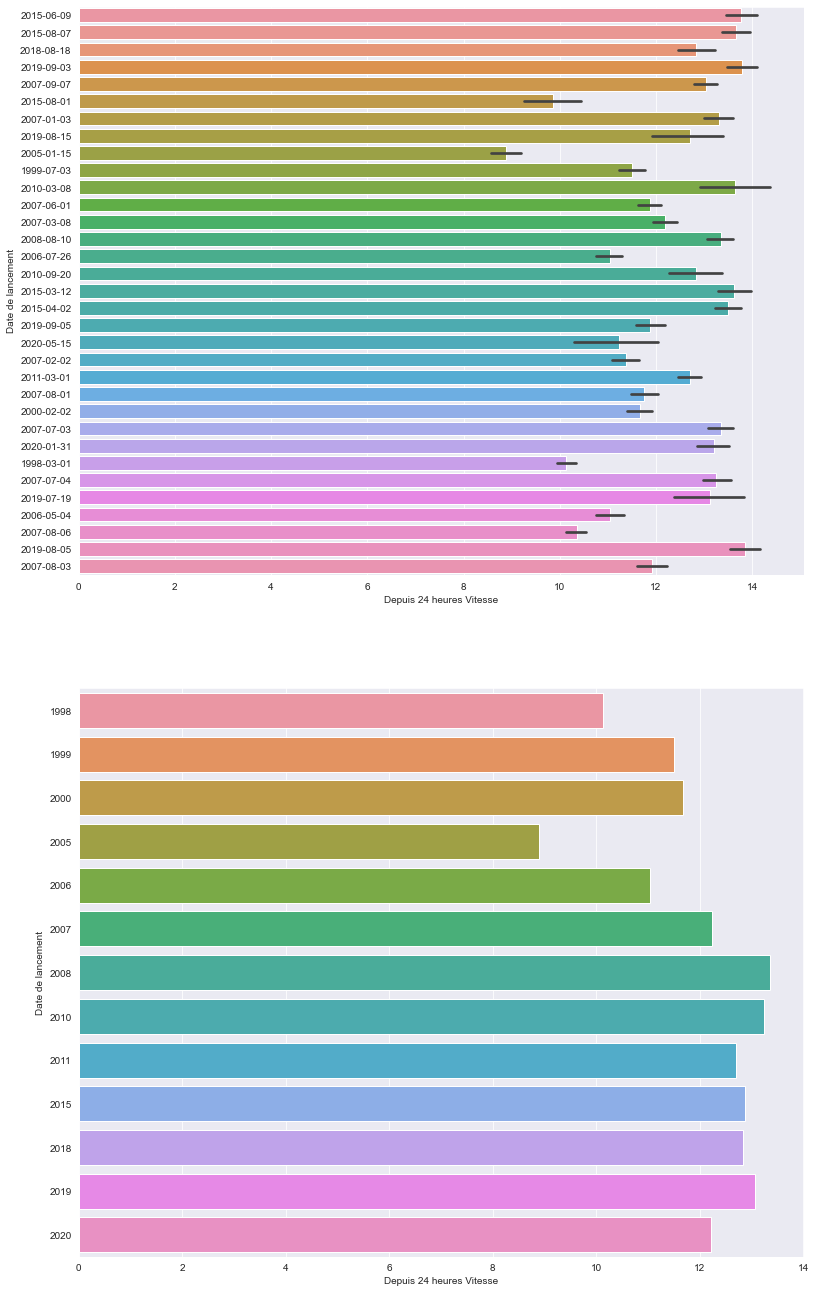

In [17]:
fig4,ax = plt.subplots(2,1,figsize=(13,23))
#Affichage de toutes les dates
sns.barplot(x=df["Depuis 24 heures Vitesse"],y=df["Date de lancement"].dt.date,ax=ax[0])

#Resample par années
var=df.pivot_table(index="Date de lancement",values="Depuis 24 heures Vitesse").resample("Y").mean().dropna(axis=0).reset_index(level=0)
sns.barplot(x=var["Depuis 24 heures Vitesse"],y=var["Date de lancement"].dt.year.astype(str),ax=ax[1])

On remarque que la date de fabrication n'est pas vraiement significative sur la vitesse

### Analyse de séries temporelles

#### Evolution du rang en fonction du temps

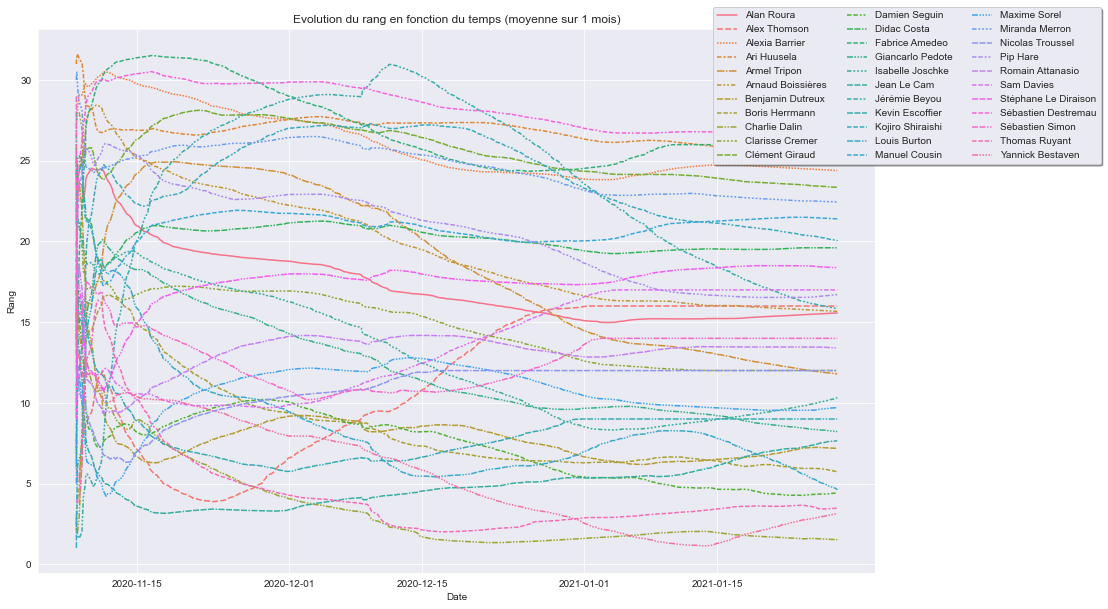

In [18]:

#Création d'un nouveau df avec une moyenne glissante sur 1 mois, remplissage des NA par interpolation
dfrang = df.pivot_table(values='Rang', index='Date',columns="Skipper",aggfunc='mean').interpolate().rolling('30d').mean()

#Tracé des données
fig5=plt.figure(figsize=(15, 10))
sns.lineplot(data=dfrang)
plt.xlabel("Date")
plt.ylabel("Rang")
plt.title("Evolution du rang en fonction du temps (moyenne sur 1 mois)")
plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

On s'appercoit que le rang est très variables les 2 premières semaines. Par la suite, les personnes classées en dessous de la 10ème place gardent leurs rangs pratiquement stable.
A l'inverse les 10 premières places continuent d'être très variables, le podium quant à lui jusqu'aux derniers jours.

#### Evolution de la vitesse en fonction du temps

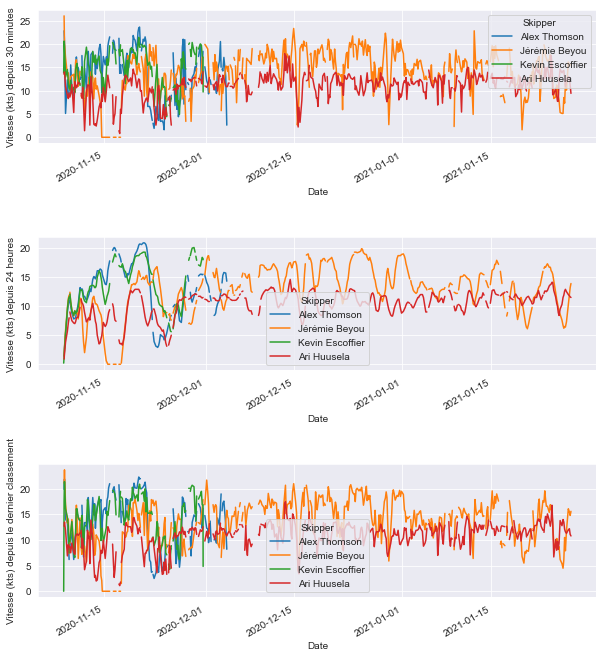

In [19]:
fig, axes = plt.subplots(3,1,figsize=(10, 12))

df.pivot_table(index='Date',columns="Skipper",
               values="Depuis 30 minutes Vitesse")[Skipper_choice].plot(ax=axes[0],ylabel="Vitesse (kts) depuis 30 minutes")

df.pivot_table(index='Date',columns="Skipper",
               values="Depuis 24 heures Vitesse")[Skipper_choice].plot(ax=axes[1],ylabel="Vitesse (kts) depuis 24 heures")

df.pivot_table(index='Date',columns="Skipper",
               values="Depuis le dernier classement Vitesse")[Skipper_choice].plot(ax=axes[2],
                                                                                    ylabel="Vitesse (kts) depuis le dernier classement")

fig.subplots_adjust(hspace=0.7)
for axe in axes:
    axe.set_xlabel("Date")

### Carte avec les routes d'un ou plusieurs voiliers.

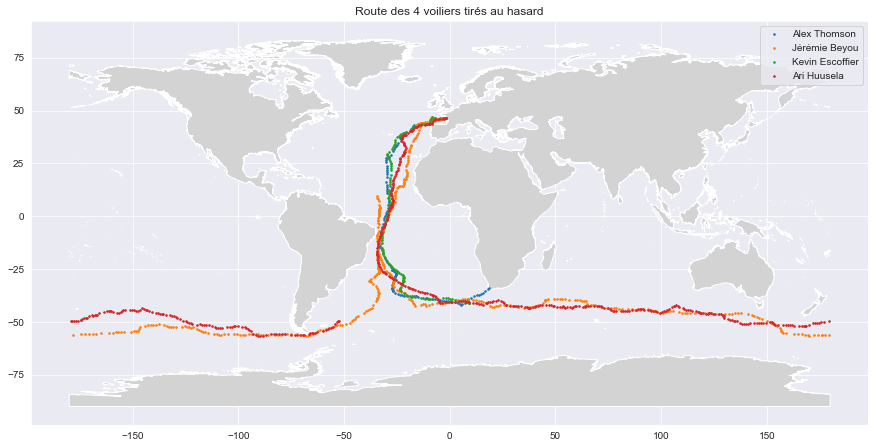

In [20]:
#Création d'un geoDatFrame à partir du DataFrame de base
gdf=df[["Skipper","Longitude","Latitude"]]#Sélection des colonnes
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))#Création d'une colonne geometry

#Tracé de la carte du monde téléchargée sur naturalearthdata
fig,ax = plt.subplots(figsize=(15,15))
shp_path = "ne_10m_land/ne_10m_land.shp"
mapland = gpd.read_file(shp_path)
mapland.plot(ax=ax,color='lightgrey')

#Tracé des routes des 4 Skippers
for element in Skipper_choice:
    gdf.loc[gdf["Skipper"]==element,"geometry"].plot(ax=ax,markersize=2.5,label=element)
plt.legend()
plt.title("Route des 4 voiliers tirés au hasard")
plt.show()

### Story telling

In [21]:
#Résultats finaux de la course
def resultat_course():
    data = pd.read_excel("data/vendeeglobe_20210305_080000.xlsx",header=4,skipfooter=4)

    data = data[["Unnamed: 1", "Unnamed: 2","Unnamed: 3","Unnamed: 7","Unnamed: 8","Vitesse\nSpeed.1","Distance\nDistance.1"]]
    data.columns=['Rang Final','Nat. / Voile','Skipper / Bateau',"Date d'arrivée","Temps de course","Vitesse","Distance"]
    data['Rang Final'] = data['Rang Final'].str.split('\n').str[0]
    data[['Skipper','Bateau']]=data['Skipper / Bateau'].str.split('\n',expand=True)
    data[['Nationalité','Num. Voile']] = data['Nat. / Voile'].str.replace('\n','').str.split(' ',expand=True)
    data = data.drop(['Nat. / Voile','Skipper / Bateau'],axis=1)
    
    data["Rang Final"]=data["Rang Final"].str.replace("RET","ABANDON")
    
    
    #Conversion temps de course en timedelta
    data["Temps de course"]=data["Temps de course"].astype(str).apply(lambda x:x.split('\n')[0])
    data["Temps de course"]=data["Temps de course"].astype(str).apply(lambda x:x.replace('s',''))
    data["Temps de course"]=data["Temps de course"].astype(str).apply(lambda x:x.replace('j',' days'))
    data["Temps de course"]=data["Temps de course"].astype(str).apply(lambda x:x.replace('h ',':'))
    data["Temps de course"]=data["Temps de course"].astype(str).apply(lambda x:x.replace('min ',':'))

    data["Temps de course"]=data["Temps de course"].apply(lambda x: pd.to_timedelta(x))

    #Conversion Date d'arrivée en date time
    data["Date d'arrivée"]=data["Date d'arrivée"].astype(str).apply(lambda x:x.split("FR")[0])
    data["Date d'arrivée"]=pd.to_datetime(data["Date d'arrivée"])

    #Conversion Vitesse en float
    data["Vitesse"]=data["Vitesse"].astype(str).apply(lambda x:x.split(" ")[0])
    data["Vitesse"]=pd.to_numeric(data["Vitesse"],errors="coerce")

    #Conversion Distance en float
    data["Distance"]=data["Distance"].astype(str).apply(lambda x:x.split(" ")[0])
    data["Distance"]=pd.to_numeric(data["Distance"],errors="coerce")

    #Reordonner les colonnes
    data=data.iloc[:, [0,5,6,7,8,1,2,4,3]] #reordonner les colonnes

    #Jointure avec les caractéristiques techniques

    list_noms = list(infos_bateaux)
    list_noms.sort()
    mapping_noms = {data["Skipper"].sort_values(ignore_index=True)[i]:list_noms[i] for i in range(len(list_noms))}
    data["Skipper"]=data["Skipper"].map(mapping_noms)

    dfcarac = pd.DataFrame(infos_bateaux).transpose() #caracteristiques to dataframe

    data = (data.merge(dfcarac, left_on='Skipper', right_index=True,copy=False))
    data=data.drop("Bateau_x",axis=1) #Suppression doublon
    data=data.drop("Numéro de voile",axis=1) #Suppression doublon
    data.rename(columns = {'Bateau_y' : 'Bateau'}, inplace = True)
    data.loc[data['Nombre de dérives'].str.contains("foil"),'Nombre de dérives'] = 'foils' #remplacer les 'foiler' par 'foils'
    
    #Conversion Date de lancement en datetime
    data["Date de lancement"]=data["Date de lancement"].astype(str).apply(lambda x:datetime.datetime.strptime(x,"%d %B %Y"))
    return data

In [22]:
df_resultats=resultat_course()

#### Classement final

In [23]:
df_resultats[["Rang Final","Skipper","Bateau"]]

,Rang Final,Skipper,Bateau
0,1,Yannick Bestaven,Maître Coq Iv
1,2,Charlie Dalin,Apivia
2,3,Louis Burton,Bureau Vallee 2
3,4,Jean Le Cam,Yes We Cam!
4,5,Boris Herrmann,Seaexplorer - Yacht Club De Monaco
5,6,Thomas Ruyant,Linkedout
6,7,Damien Seguin,Groupe Apicil
7,8,Giancarlo Pedote,Prysmian Group
8,9,Benjamin Dutreux,Omia - Water Family
9,10,Maxime Sorel,V And B-Mayenne


#### Impact de la date de lancement sur le rang final

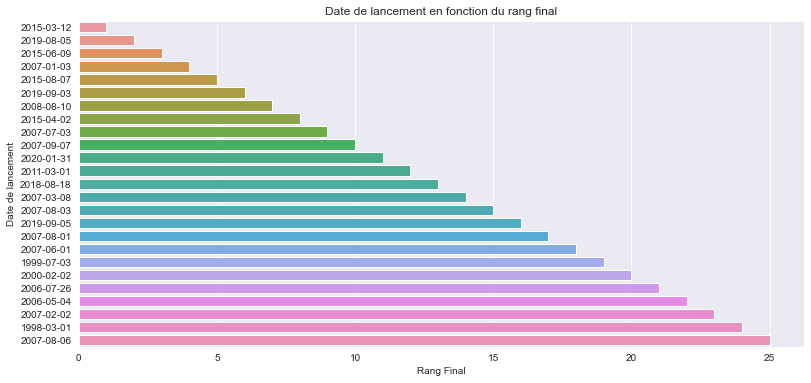

In [24]:
fig=plt.figure(figsize=(13,6))
var = df_resultats.loc[df_resultats["Rang Final"]!="ABANDON",["Date de lancement","Rang Final"]]
sns.barplot(x=var["Rang Final"].astype(int),y=var["Date de lancement"].dt.date)
plt.title("Date de lancement en fonction du rang final")
plt.show()

#### Quel est l'équipage qui est arrivé le plus premier ?

In [25]:
df.loc[df["Rang"]==1,["Rang","Skipper"]].value_counts()

Rang  Skipper         
1     Charlie Dalin       225
      Yannick Bestaven    159
      Alex Thomson         46
      Thomas Ruyant        20
      Jean Le Cam           9
      Maxime Sorel          8
      Louis Burton          7
      Damien Seguin         5
      Jérémie Beyou         5
      Benjamin Dutreux      1
dtype: int64

In [26]:
df[["Rang","Skipper","Bateau"]].groupby("Rang").get_group(1).max()

Rang                      1
Skipper    Yannick Bestaven
Bateau          Yes We Cam!
dtype: object

#### Bateau le plus ancien

In [27]:
print(df_resultats.loc[df_resultats["Date de lancement"].idxmin(),["Bateau","Date de lancement"]])

Bateau                  Tse -  4Myplanet
Date de lancement    1998-03-01 00:00:00
Name: 23, dtype: object


### Machine Learning : Prédiction du classement

Le but est de prédire le prochain classement 

In [28]:
#Selection des colonnes
colonnes =["Skipper",'Longueur', 'Largeur', "Tirant d'eau", 'Nombre de dérives',
       'Hauteur mât', 'Voile quille', 'Surface de voiles au près',
       'Surface de voiles au portant','DTF','DTL','Depuis 24 heures Vitesse',"Depuis 24 heures Distance","Rang"]

df_ml=df[colonnes]
X = pd.get_dummies(data=df_ml[df_ml.columns[:-1]], drop_first=True)
Y=df_ml["Rang"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

print("Taille de X_train :",X_train.shape)
print("Taille de X_test :",X_test.shape)
print("Taille de Y_train :",y_train.shape)
print("Taille de Y_test :",y_test.shape)

Taille de X_train : (9648, 52)
Taille de X_test : (4136, 52)
Taille de Y_train : (9648,)
Taille de Y_test : (4136,)


In [30]:
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.8805246464878581

On remarque que l'accuracy est correcte

In [31]:
model.coef_

array([ 3.35955365e+04, -4.55903619e+08, -1.40520892e+07,  7.30728784e+06,
        6.78018510e+04,  9.70057892e+04,  2.70604939e-04,  4.56339753e-04,
        3.73953164e-01, -2.25130987e-02, -1.84482596e+08, -3.48700374e+07,
        9.02941740e+07, -1.18301274e+08, -2.49545654e+07,  5.76850799e+07,
        3.00359780e+06,  6.05306198e+07, -8.01778636e+05,  1.98551963e+07,
        6.30255074e+07, -1.10338372e+08,  1.25690601e+07,  2.82308680e+06,
       -4.41711295e+07,  9.55480101e+07,  5.86844617e+07, -1.05638512e+08,
        2.62023571e+07,  4.45525919e+07,  2.35914149e+07, -7.18660829e+07,
       -1.52553524e+08, -5.38762769e+06, -6.47059211e+07,  5.71340397e+07,
       -2.81527018e+07,  1.86134580e+07, -1.36282051e+07, -1.17228305e+07,
        2.61083998e+07,  1.18055178e+07,  2.35913368e+07,  4.17673942e+07,
       -1.17145404e+07, -1.78043883e+07,  1.66178327e+07,  1.18076666e+07,
       -2.49601100e+07,  2.35935015e+07,  8.22639957e+07,  3.12211894e+07])

In [32]:
resultats_regression = pd.DataFrame({'Y_test':y_test, 'Y_prédit':model.predict(X_test)})
resultats_regression.head(15)

,Y_test,Y_prédit
10,11,13.726840
19,20,21.595050
10,11,7.435967
5,6,3.593647
20,21,19.297240
24,25,24.607551
16,17,18.932677
5,6,3.382613
19,20,22.039015
15,16,14.769643
